In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scipy.signal as sp
from scipy import signal as sg  # Renomeando para evitar conflitos



## Funções

In [40]:
def sliding_window(signal, window_size: int, step_size: int):
    """
    Implementa uma janela de observação deslizante ao longo de um sinal.
    
    Parameters:
    ----------
    signal: np.array- ou list-like
        Sinal de entrada; pode ser uma lista ou um array numpy.
    
    window_size: int
        Tamanho da janela de observação, dado em elementos do sinal de entrada.
    
    step_size: int
        Valor do deslocamento da janela de observada, em elementos do sinal de
        entrada.
    
    Returns:
    --------
    Um gerador Python que retorna uma seção do sinal de entrada a cada iteração.
    """
    for i in range(0, len(signal) - window_size + 1, step_size):
        yield signal[i:i+window_size]



In [42]:
def calculate_euclidean_norms(df):
    """
    Calcula as normas euclidianas para os sinais do acelerômetro e giroscópio da coleira.
    
    Parameters:
    df (pandas.DataFrame): DataFrame contendo as colunas ANeck_[x,y,z] e GNeck_[x,y,z]
    
    Returns:
    tuple: (norma_acelerometro, norma_giroscopio)
    """
    # Cálculo da norma euclidiana do acelerômetro
    acc_norm = np.sqrt(
        df['ANeck_x']**2 + 
        df['ANeck_y']**2 + 
        df['ANeck_z']**2
    )
    
    # Cálculo da norma euclidiana do giroscópio
    gyro_norm = np.sqrt(
        df['GNeck_x']**2 + 
        df['GNeck_y']**2 + 
        df['GNeck_z']**2
    )
    
    return acc_norm, gyro_norm

In [43]:
# Função para visualizar os resultados
def plot_norms(t_sec, acc_norm, gyro_norm, sample_seconds=10):
    """
    Plota as normas euclidianas dos sinais.
    
    Parameters:
    t_sec (array): Vetor de tempo
    acc_norm (array): Norma do acelerômetro
    gyro_norm (array): Norma do giroscópio
    sample_seconds (int): Quantidade de segundos para mostrar
    """

    
    # Encontrar índices para o intervalo de tempo desejado
    idx = t_sec <= sample_seconds
    
    plt.figure(figsize=(15, 6))
    
    # Plot do acelerômetro
    plt.subplot(2, 1, 1)
    plt.plot(t_sec[idx], acc_norm[idx])
    plt.title('Norma Euclidiana do Acelerômetro')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Magnitude (m/s²)')
    plt.grid(True)
    
    # Plot do giroscópio
    plt.subplot(2, 1, 2)
    plt.plot(t_sec[idx], gyro_norm[idx])
    plt.title('Norma Euclidiana do Giroscópio')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Magnitude (rad/s)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [53]:
def apply_hann_window(input_signal, fs=100):
    """
    Aplica janelamento de Hann ao sinal com superposição de 50%.
    
    Parameters:
    ----------
    input_signal: np.array
        Sinal de entrada
    fs: int
        Frequência de amostragem em Hz
    
    Returns:
    --------
    list: Lista com as janelas processadas
    """
    # Converter para numpy array se for pandas Series
    signal_array = np.array(input_signal)
    
    # Calcula o tamanho da janela para 2 segundos
    window_size = 2 * fs  # 2 segundos * 100 Hz = 200 amostras
    step_size = window_size // 2  # 50% de superposição
    
    # Cria a janela de Hann
    hann_window = sg.windows.hann(window_size)  # Usando sg em vez de signal
    
    # Aplica o janelamento
    windowed_signals = []
    for window in sliding_window(signal_array, window_size, step_size):
        if len(window) == window_size:  # Garante que a janela está completa
            windowed_signals.append(window * hann_window)
    
    return windowed_signals


In [54]:
def plot_windowed_signal(original_signal, windowed_signals, fs=100):
    """
    Plota o sinal original e algumas janelas processadas para comparação.
    
    Parameters:
    ----------
    original_signal: np.array
        Sinal original antes do janelamento
    windowed_signals: list
        Lista de janelas processadas
    fs: int
        Frequência de amostragem em Hz
    """
    import matplotlib.pyplot as plt
    
    # Criar vetor de tempo para o sinal original
    t_original = np.arange(len(original_signal)) / fs
    
    plt.figure(figsize=(15, 8))
    
    # Plotar sinal original
    plt.subplot(2, 1, 1)
    plt.plot(t_original, original_signal)
    plt.title('Sinal Original')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Plotar algumas janelas processadas
    plt.subplot(2, 1, 2)
    t_window = np.arange(len(windowed_signals[0])) / fs
    
    # Plotar as primeiras 3 janelas
    for i, window in enumerate(windowed_signals[:3]):
        plt.plot(t_window + i*2, window, label=f'Janela {i+1}')
    
    plt.title('Janelas Processadas com Hann (50% superposição)')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## Filtros

In [59]:
def design_elliptic_highpass(fs=100):
    """
    Projeta um filtro passa-altas Elíptico.
    
    Parameters:
    ----------
    fs : int
        Frequência de amostragem em Hz
    
    Returns:
    -------
    tuple : (b, a) coeficientes do filtro
    """
    # Parâmetros do filtro
    gp = 1      # Ganho na banda de passagem (dB)
    gs = 50     # Atenuação mínima na banda de rejeição (dB)
    fp = 1      # Frequência de passagem (Hz)
    fs_stop = 0.5    # Frequência de rejeição (Hz)
    
    # Projeto do filtro
    b, a = sp.iirdesign(
        wp=fp,
        ws=fs_stop,
        gpass=gp,
        gstop=gs,
        fs=fs,
        analog=False,
        ftype='ellip',
        output='ba'
    )
    
    return b, a

In [60]:
def design_butterworth_lowpass(fs=100):
    """
    Projeta um filtro passa-baixas Butterworth.
    
    Parameters:
    ----------
    fs : int
        Frequência de amostragem em Hz
    
    Returns:
    -------
    tuple : (b, a) coeficientes do filtro
    """
    # Parâmetros do filtro
    gp = 1      # Ganho na banda de passagem (dB)
    gs = 50     # Atenuação mínima na banda de rejeição (dB)
    fp = 10     # Frequência de passagem (Hz)
    fs_stop = 25     # Frequência de rejeição (Hz)
    
    # Projeto do filtro
    b, a = sp.iirdesign(
        wp=fp,
        ws=fs_stop,
        gpass=gp,
        gstop=gs,
        fs=fs,
        analog=False,
        ftype='butter',
        output='ba'
    )
    
    return b, a

In [22]:
def apply_filters(signal, fs=100):
    """
    Aplica os filtros passa-altas Elíptico e passa-baixas Butterworth em sequência.
    
    Parameters:
    ----------
    signal : array_like
        Sinal de entrada
    fs : int
        Frequência de amostragem em Hz
    
    Returns:
    -------
    array_like : Sinal filtrado
    """
    # Projeta os filtros
    b_ellip, a_ellip = design_elliptic_highpass(fs)
    b_butter, a_butter = design_butterworth_lowpass(fs)
    
    # Aplica os filtros em sequência
    signal_highpass = sp.filtfilt(b_ellip, a_ellip, signal)
    signal_filtered = sp.filtfilt(b_butter, a_butter, signal_highpass)
    
    return signal_filtered


In [39]:

def plot_filter_response(fs = 100):
    """
    Plota a resposta em frequência dos filtros.
    """
    fs = np.abs(fs) # Frequência de amostragem
    
    # Obtém os coeficientes dos filtros
    b_ellip, a_ellip = design_elliptic_highpass(fs)
    b_butter, a_butter = design_butterworth_lowpass(fs)
    
    # Calcula as respostas em frequência
    w, h_ellip = sp.freqz(b_ellip, a_ellip, fs=fs)
    w, h_butter = sp.freqz(b_butter, a_butter, fs=fs)
    
    # Converte para dB
    h_ellip_db = 20 * np.log10(np.abs(h_ellip))
    h_butter_db = 20 * np.log10(np.abs(h_butter))
    
    # Plotting
    plt.figure(figsize=(15, 10))



    # Resposta em Magnitude
    plt.subplot(2, 1, 1)
    #plt.semilogx(w, h_ellip_db, label='Elíptico Passa-altas')
    #plt.semilogx(w, h_butter_db, label='Butterworth Passa-baixas')
    plt.plot(w, h_ellip_db, label='Elíptico Passa-altas')
    plt.plot(w, h_butter_db, label='Butterworth Passa-baixas')    
    plt.grid(True)
    plt.ylabel('Magnitude (dB)')
    plt.xlabel('Frequência (Hz)')
    plt.title('Resposta em Frequência dos Filtros')
    plt.legend()
    plt.axvline(0.5, color='r', linestyle='--', alpha=0.5, label='0.5 Hz')
    plt.axvline(10, color='g', linestyle='--', alpha=0.5, label='10 Hz')
    
    # Fase
    plt.subplot(2, 1, 2)
    #plt.semilogx(w, np.unwrap(np.angle(h_ellip)), label='Elíptico Passa-altas')
    #plt.semilogx(w, np.unwrap(np.angle(h_butter)), label='Butterworth Passa-baixas')
    plt.plot(w, np.unwrap(np.angle(h_ellip)), label='Elíptico Passa-altas')
    plt.plot(w, np.unwrap(np.angle(h_butter)), label='Butterworth Passa-baixas')
    plt.grid(True)
    plt.ylabel('Fase (rad)')
    plt.xlabel('Frequência (Hz)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    


In [62]:
def plot_filtered_signal(original_signal, filtered_signal, fs=100):
    """
    Plota o sinal original e filtrado para comparação.
    
    Parameters:
    ----------
    original_signal : array_like
        Sinal original
    filtered_signal : array_like
        Sinal filtrado
    fs : int
        Frequência de amostragem em Hz
    """
    t = np.arange(len(original_signal)) / fs
    
    plt.figure(figsize=(15, 8))
    plt.plot(t, original_signal, label='Original', alpha=0.7)
    plt.plot(t, filtered_signal, label='Filtrado', alpha=0.7)
    plt.grid(True)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.title('Comparação entre Sinal Original e Filtrado')
    plt.legend()
    plt.show()

## Comportamento

In [73]:
def get_behavior_for_window(behaviors_in_window):
    """
    Determina o comportamento predominante em uma janela.
    
    Parameters:
    -----------
    behaviors_in_window: list
        Lista de comportamentos na janela (pode incluir valores de Behavior_1, Behavior_2 e Behavior_3)
    
    Returns:
    --------
    str ou None:
        Comportamento predominante se atender ao critério de 75%, None caso contrário
    """
    # Remove valores nulos ou vazios
    valid_behaviors = [b for b in behaviors_in_window if isinstance(b, str) and b.strip() != '']
    
    if not valid_behaviors:
        return None
    
    # Conta ocorrências de cada comportamento
    behavior_counts = Counter(valid_behaviors)
    
    # Comportamentos de interesse
    target_behaviors = {'galloping', 'standing', 'walking'}
    
    # Calcula a proporção do comportamento mais frequente
    total_samples = len(behaviors_in_window)
    
    for behavior in target_behaviors:
        count = behavior_counts.get(behavior, 0)
        proportion = count / total_samples
        
        if proportion >= 0.75:  # Critério de 75%
            return behavior
            
    return None


In [74]:
def assign_behaviors_to_windows(df, window_indices, behaviors_of_interest=['galloping', 'standing', 'walking']):
    """
    Associa comportamentos às janelas do sinal usando as três colunas de comportamento.
    
    Parameters:
    -----------
    df: pandas.DataFrame
        DataFrame original com as colunas Behavior_1, Behavior_2 e Behavior_3
    window_indices: list
        Lista de índices que definem cada janela
    behaviors_of_interest: list
        Lista dos comportamentos de interesse
        
    Returns:
    --------
    list:
        Lista de comportamentos predominantes para cada janela
    dict:
        Estatísticas sobre a classificação das janelas
    """
    window_behaviors = []
    stats = {
        'total_windows': len(window_indices),
        'classified_windows': 0,
        'behavior_counts': {b: 0 for b in behaviors_of_interest},
        'unclassified_windows': 0
    }
    
    for window_start in range(0, len(window_indices) - 1):
        start_idx = window_indices[window_start]
        end_idx = window_indices[window_start + 1]
        
        # Coleta todos os comportamentos da janela
        behaviors = []
        for i in range(start_idx, end_idx):
            behaviors.extend([
                df.iloc[i]['Behavior_1'],
                df.iloc[i]['Behavior_2'],
                df.iloc[i]['Behavior_3']
            ])
        
        # Determina o comportamento predominante
        predominant_behavior = get_behavior_for_window(behaviors)
        window_behaviors.append(predominant_behavior)
        
        # Atualiza estatísticas
        if predominant_behavior:
            stats['classified_windows'] += 1
            stats['behavior_counts'][predominant_behavior] += 1
        else:
            stats['unclassified_windows'] += 1
    
    return window_behaviors, stats

In [25]:
def print_behavior_stats(stats):
    """
    Imprime as estatísticas de classificação das janelas.
    
    Parameters:
    -----------
    stats: dict
        Dicionário com as estatísticas de classificação
    """
    print("\nEstatísticas de Classificação das Janelas:")
    print(f"Total de janelas: {stats['total_windows']}")
    print(f"Janelas classificadas: {stats['classified_windows']} ({(stats['classified_windows']/stats['total_windows']*100):.2f}%)")
    print(f"Janelas não classificadas: {stats['unclassified_windows']} ({(stats['unclassified_windows']/stats['total_windows']*100):.2f}%)")
    print("\nDistribuição dos comportamentos:")
    for behavior, count in stats['behavior_counts'].items():
        print(f"{behavior}: {count} janelas ({(count/stats['total_windows']*100):.2f}%)")



## Main

In [7]:
path    = "r:\Downloads\DogMoveData_csv_format\DogMoveData.csv"
#path2   = "r:\Downloads\DogMoveData_csv_format\DogInfo.csv"
df = pd.read_csv(path)
#df_info = pd.read_csv(path2)

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Reyso\AppData\Local\Temp\ipykernel_3060\1562673651.py:1: SyntaxWarning: invalid escape sequence '\D'
  path    = "r:\Downloads\DogMoveData_csv_format\DogMoveData.csv"


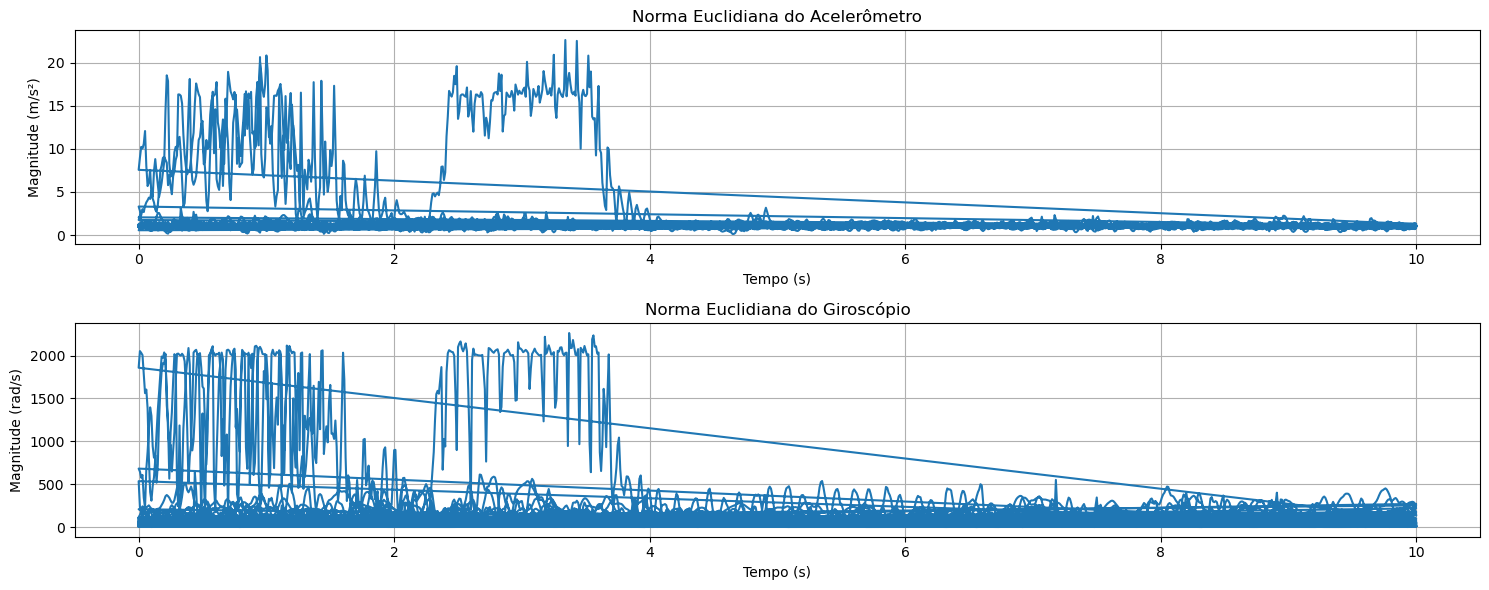

In [8]:
# Assumindo que seu DataFrame se chama 'df'
acc_norm, gyro_norm = calculate_euclidean_norms(df)

# Para visualizar os primeiros 10 segundos dos sinais
plot_norms(df['t_sec'], acc_norm, gyro_norm, sample_seconds=10)

In [55]:
# Calcular as normas euclidianas
acc_norm, gyro_norm = calculate_euclidean_norms(df)


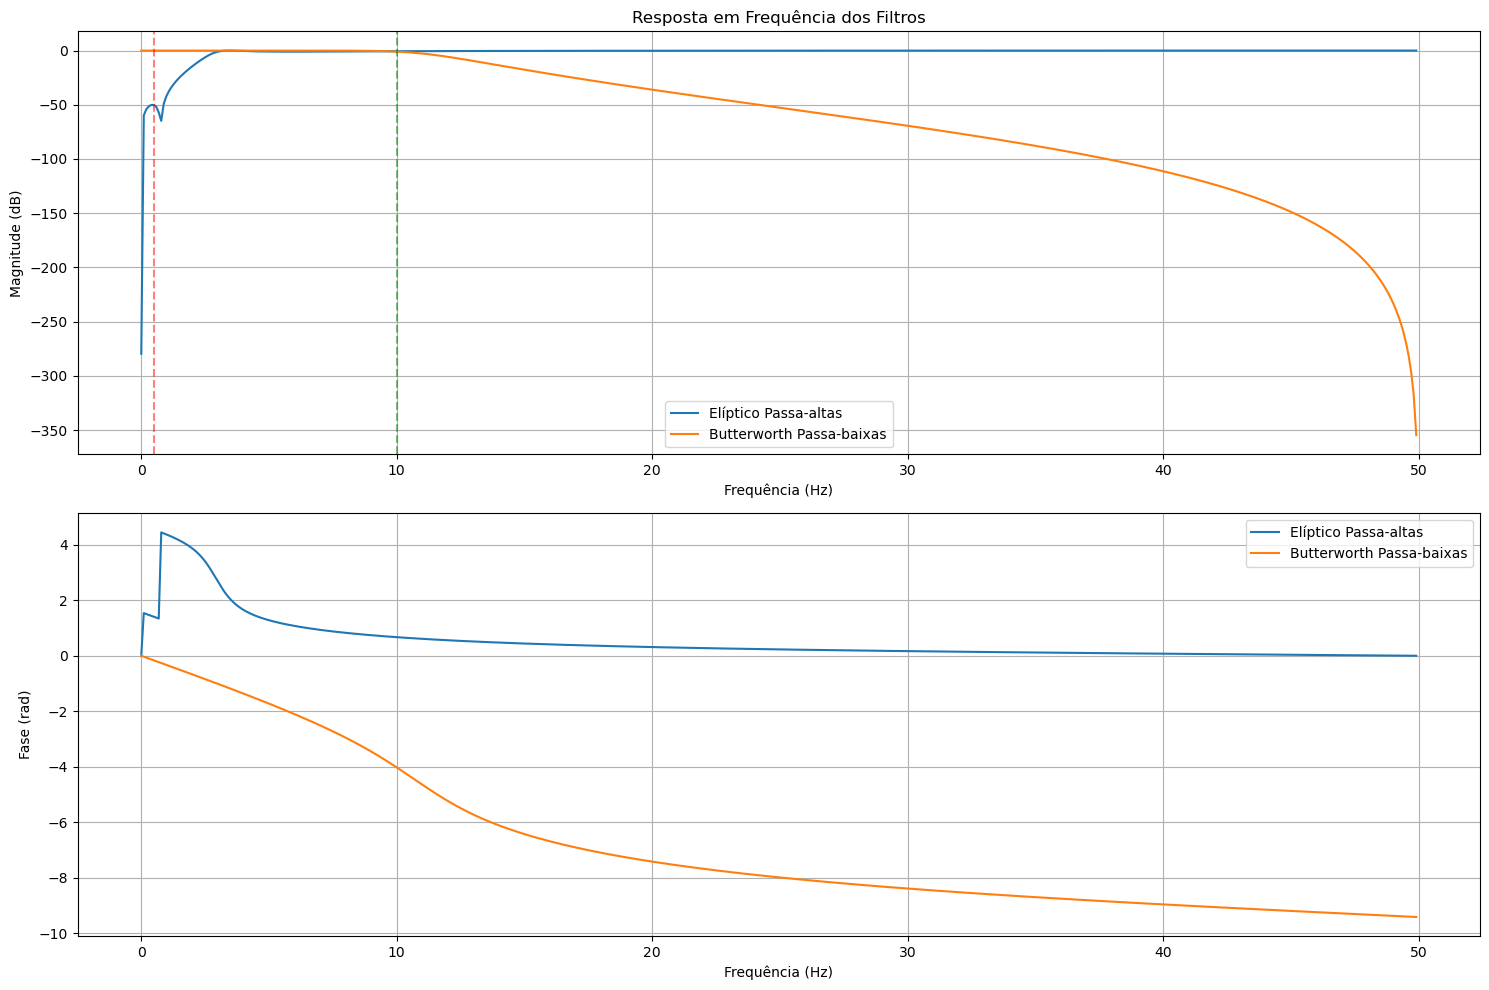

In [41]:

# 1. Visualizar a resposta em frequência dos filtros
plot_filter_response()


In [30]:

# 2. Aplicar os filtros aos sinais
acc_filtered = apply_filters(acc_norm)
gyro_filtered = apply_filters(gyro_norm)


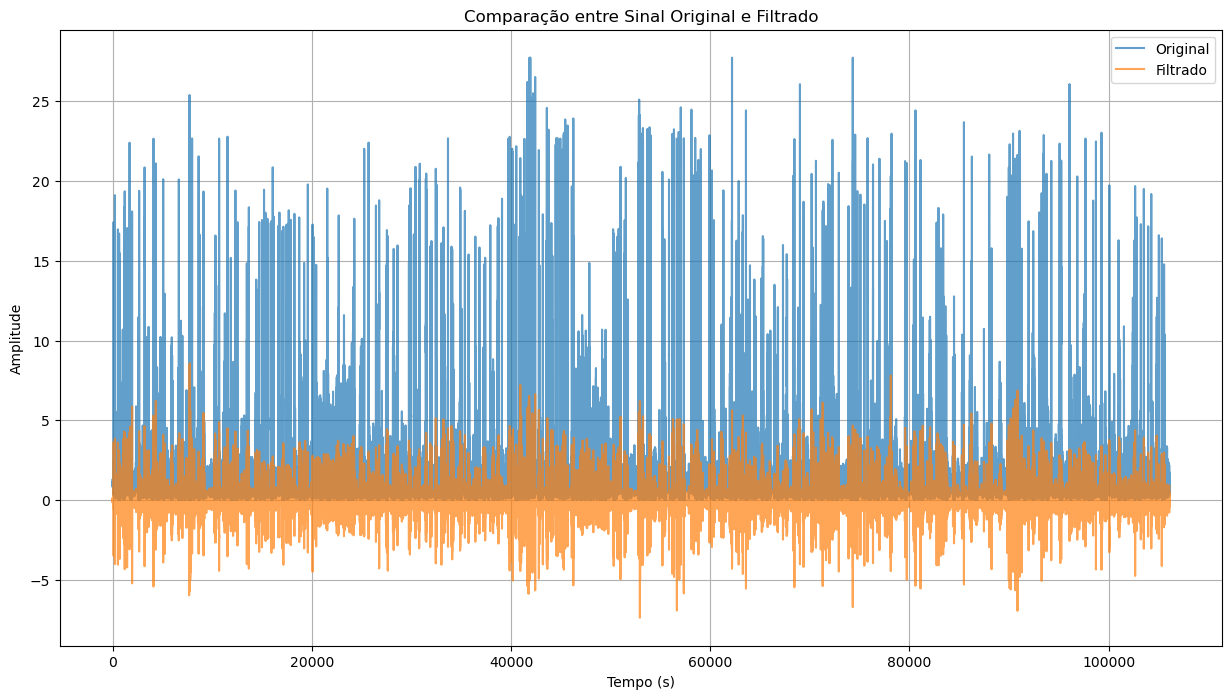

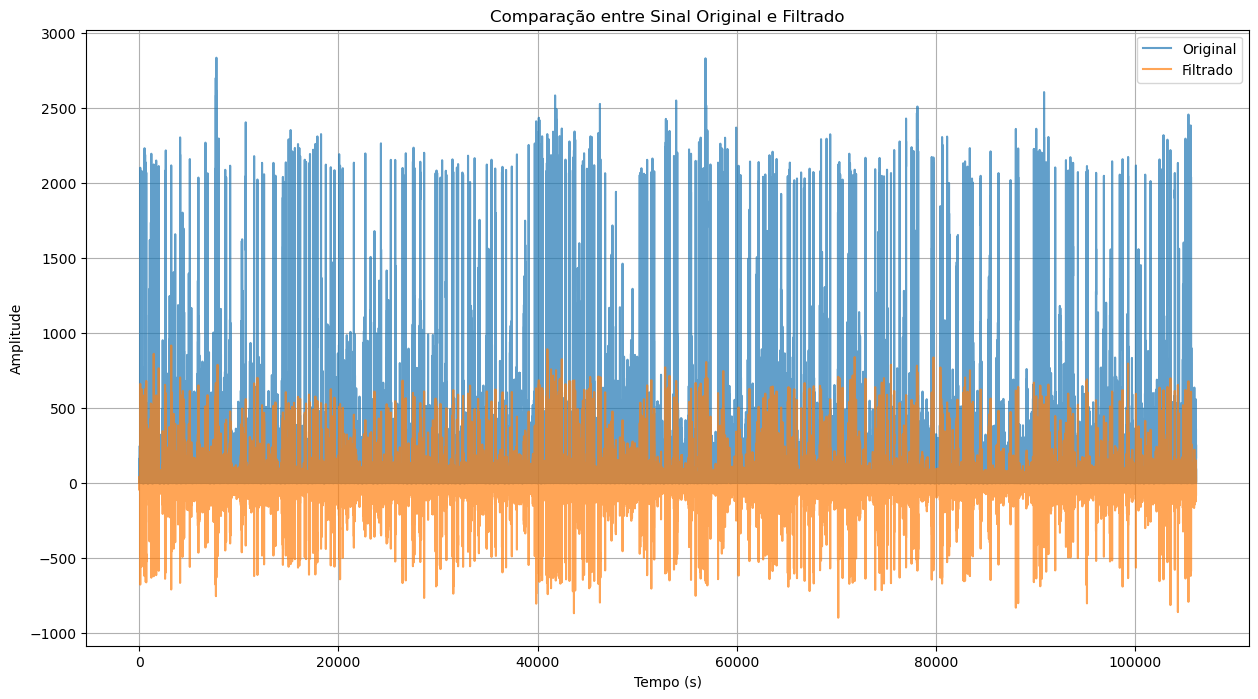

In [31]:

# 3. Visualizar os resultados
plot_filtered_signal(acc_norm, acc_filtered)
plot_filtered_signal(gyro_norm, gyro_filtered)

In [66]:

# Aplicar janelamento nos sinais
#acc_windowed = apply_hann_window(acc_norm)
#gyro_windowed = apply_hann_window(gyro_norm)
acc_windowed = apply_hann_window(acc_filtered)
gyro_windowed = apply_hann_window(gyro_filtered)


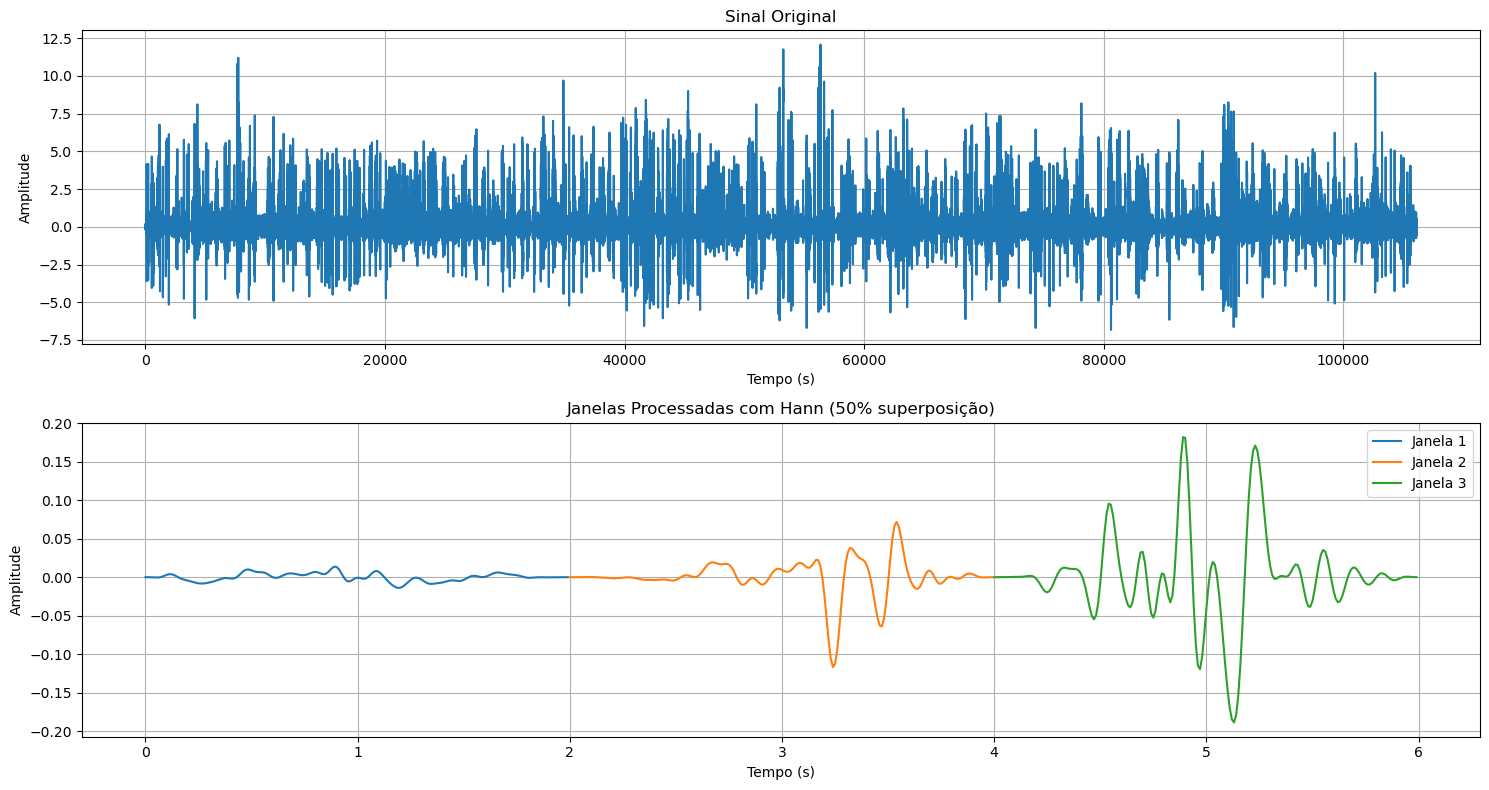

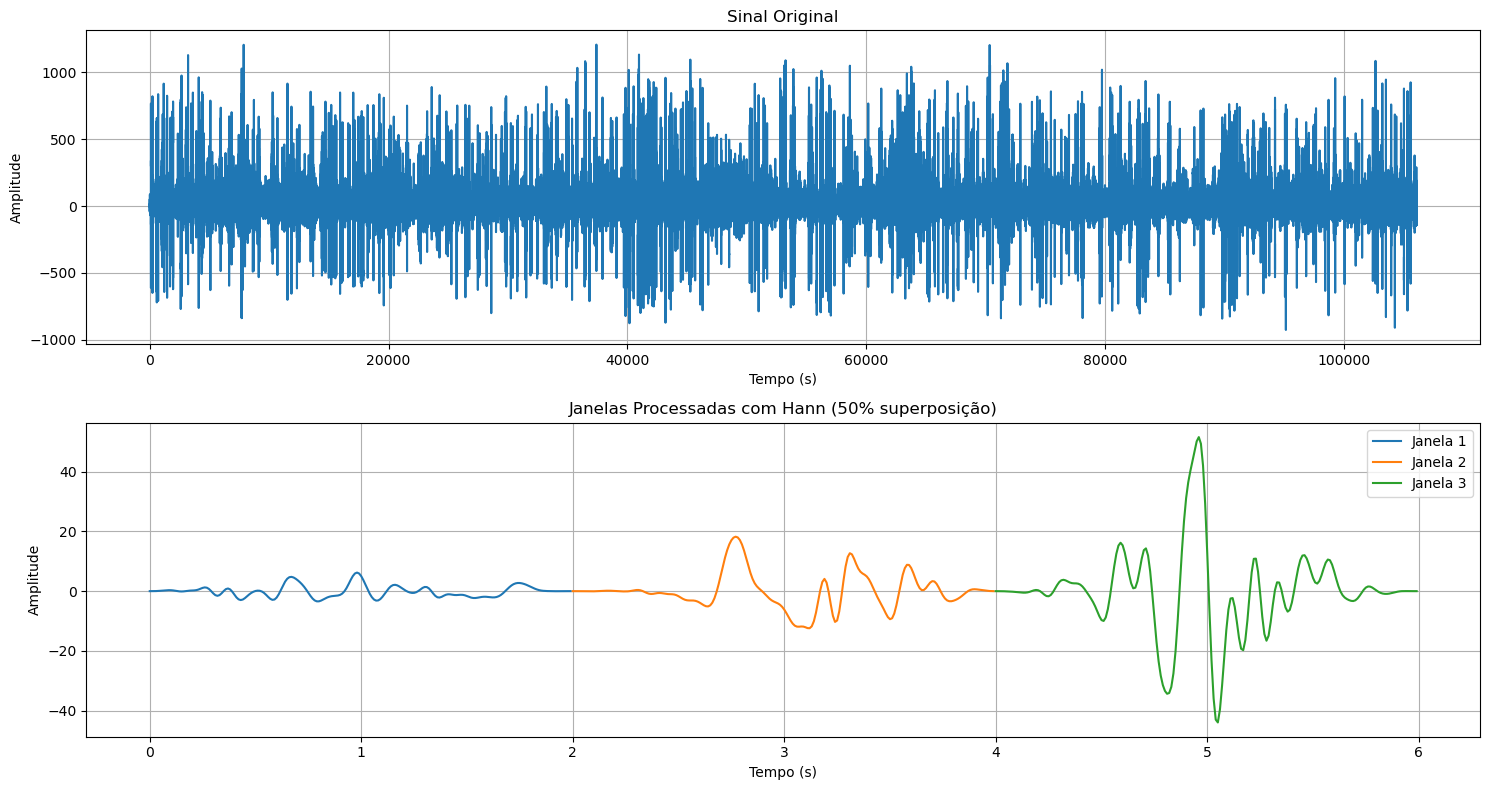

In [67]:

# Visualizar os resultados
#plot_windowed_signal(acc_norm, acc_windowed)
#plot_windowed_signal(gyro_norm, gyro_windowed)
plot_windowed_signal(acc_filtered, acc_windowed)
plot_windowed_signal(gyro_filtered, gyro_windowed)

In [76]:
# Assumindo que window_indices são os índices de início de cada janela
# Você pode obtê-los do processo de janelamento anterior
fs = 100
window_size = 2 * fs

# Criar lista de índices das janelas
window_indices = list(range(0, len(df), window_size//2))  # window_size é o tamanho da janela usado anteriormente


In [78]:

# Associar comportamentos às janelas
window_behaviors, stats = assign_behaviors_to_windows(df, window_indices)


KeyboardInterrupt: 

In [ ]:

# Imprimir estatísticas
print_behavior_stats(stats)